entering find best hyperparameters
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Train set accuracy: 99.99%


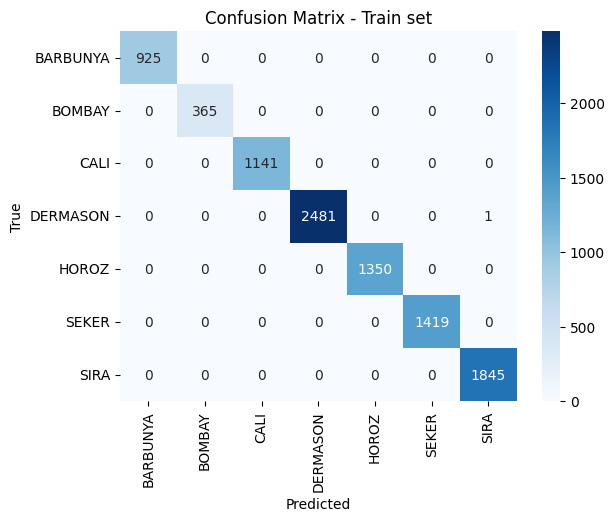

Classification report for train set:
              precision    recall  f1-score   support

    BARBUNYA       1.00      1.00      1.00       925
      BOMBAY       1.00      1.00      1.00       365
        CALI       1.00      1.00      1.00      1141
    DERMASON       1.00      1.00      1.00      2482
       HOROZ       1.00      1.00      1.00      1350
       SEKER       1.00      1.00      1.00      1419
        SIRA       1.00      1.00      1.00      1845

    accuracy                           1.00      9527
   macro avg       1.00      1.00      1.00      9527
weighted avg       1.00      1.00      1.00      9527



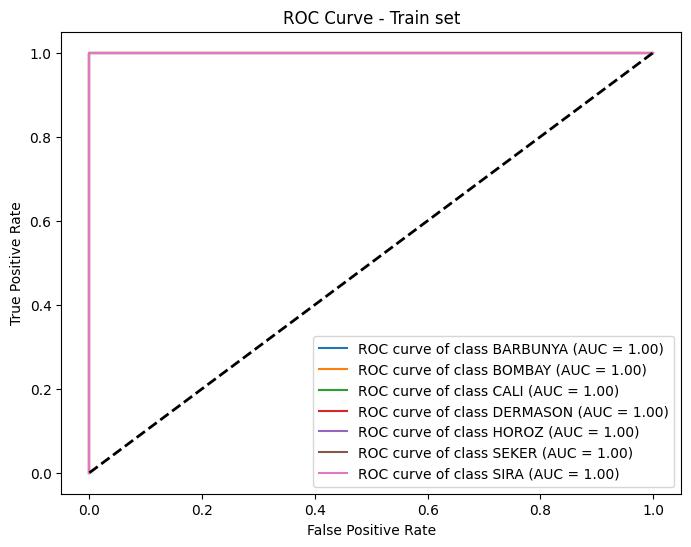

Average AUC (train set): 1.0000
Test set accuracy: 92.12%


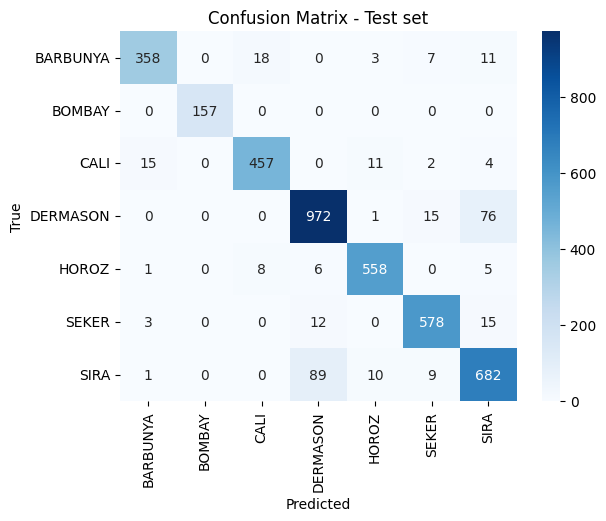

Classification report for test set:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.90      0.92       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.93      0.94       489
    DERMASON       0.90      0.91      0.91      1064
       HOROZ       0.96      0.97      0.96       578
       SEKER       0.95      0.95      0.95       608
        SIRA       0.86      0.86      0.86       791

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084



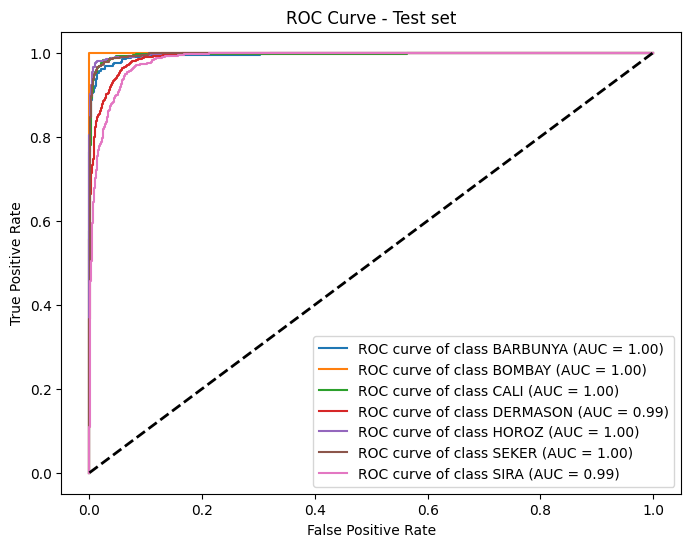

Average AUC (test set): 0.9948
Whole dataset accuracy: 97.63%


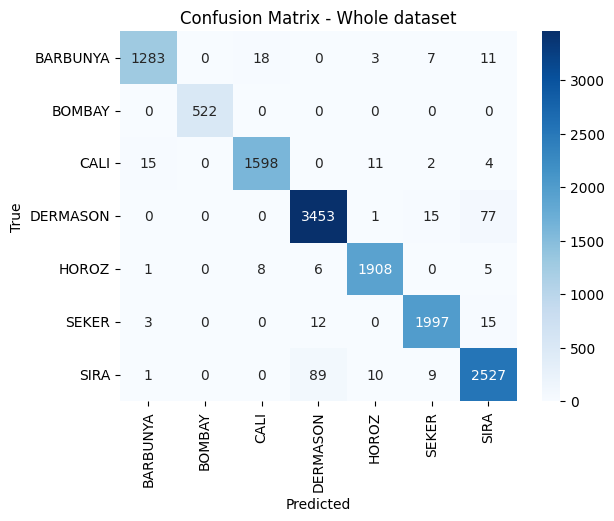

Classification report for whole dataset:
              precision    recall  f1-score   support

    BARBUNYA       0.98      0.97      0.98      1322
      BOMBAY       1.00      1.00      1.00       522
        CALI       0.98      0.98      0.98      1630
    DERMASON       0.97      0.97      0.97      3546
       HOROZ       0.99      0.99      0.99      1928
       SEKER       0.98      0.99      0.98      2027
        SIRA       0.96      0.96      0.96      2636

    accuracy                           0.98     13611
   macro avg       0.98      0.98      0.98     13611
weighted avg       0.98      0.98      0.98     13611



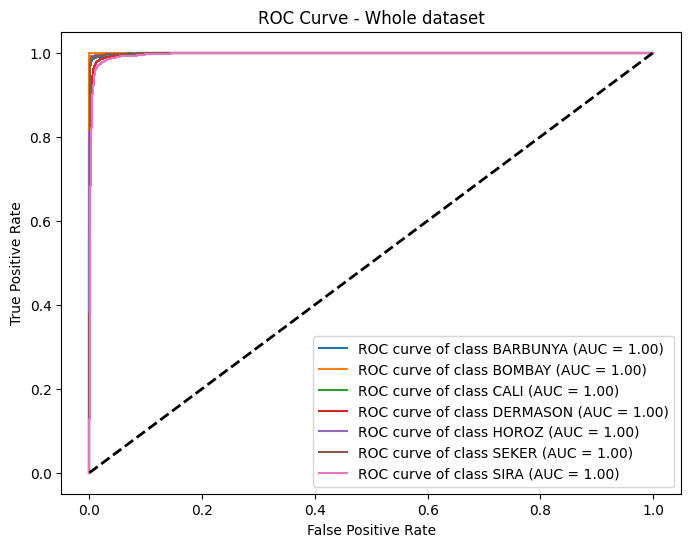

Average AUC (whole dataset): 0.9988


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Set the random seed for reproducibility
np.random.seed(42)


# Read dataset 
df = pd.read_csv("Dry_Bean_Dataset.csv")

# Separate features and target (assuming the target column is named 'Class')
X = df.drop("Class", axis=1)
y = df["Class"]

# Encode the target variable as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_train_1, X_val, y_train_1, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5]
}

print("entering find best hyperparameters")
# Tune hyperparameters by performing GridSearchCV on the training set
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    refit=True
)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)


# Retrain the model on the entire training set using the best hyperparameters
final_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=grid.best_params_["n_estimators"],
    learning_rate=grid.best_params_["learning_rate"],
    max_depth=grid.best_params_["max_depth"]
)

final_model.fit(X_train, y_train)
# Define class names from the label encoder
classes = le.classes_

# Define datasets and their names for iteration
datasets = [
    ("Train set", X_train, y_train),
    ("Test set", X_test, y_test),
    ("Whole dataset", X, y_encoded)
]

for name, X_set, y_set in datasets:
    y_pred = final_model.predict(X_set)
    accuracy = final_model.score(X_set, y_set) * 100
    print(f"{name} accuracy: {accuracy:.2f}%")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_set, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Classification report for {name.lower()}:")
    print(classification_report(y_set, y_pred, target_names=classes))
    
    # Binarize the output for ROC curve (one-vs-rest)
    y_bin = label_binarize(y_set, classes=range(len(classes)))
    if hasattr(final_model, "predict_proba"):
        y_score = final_model.predict_proba(X_set)
    else:
        y_score = final_model.decision_function(X_set)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate and print average AUC
    average_auc = np.mean([roc_auc[i] for i in range(len(classes))])
    print(f'Average AUC ({name.lower()}): {average_auc:.4f}')


/var/folders/qk/zgyqcw1j2d7_d2zbzrqgtfmw0000gn/T/ipykernel_53829/262916661.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
/var/folders/qk/zgyqcw1j2d7_d2zbzrqgtfmw0000gn/T/ipykernel_53829/262916661.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)


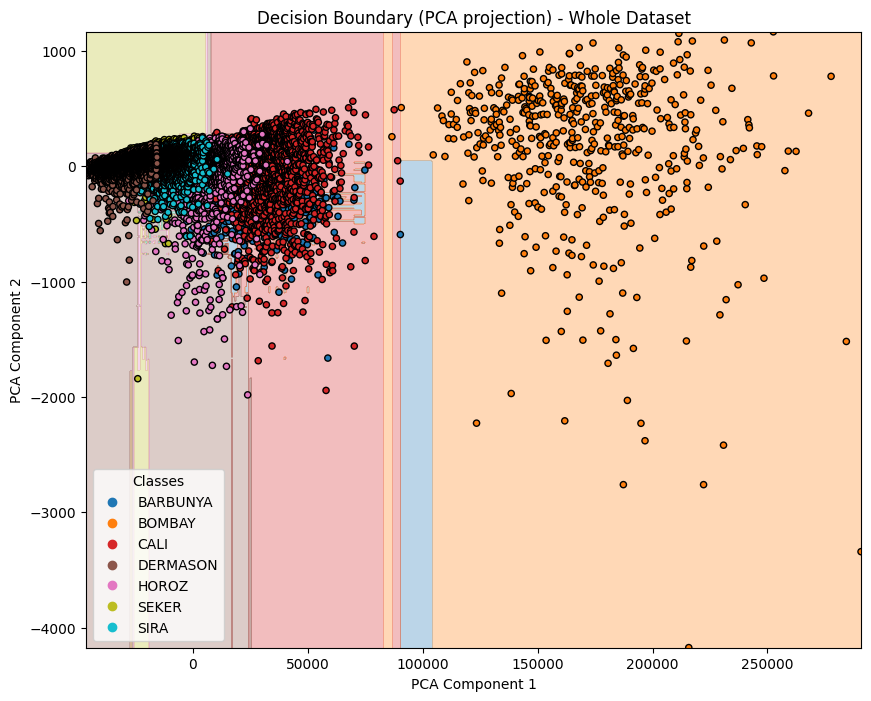

In [2]:
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit GradientBoostingClassifier on PCA-reduced data for visualization
model_vis = GradientBoostingClassifier(
    random_state=42,
    n_estimators=grid.best_params_["n_estimators"],
    learning_rate=grid.best_params_["learning_rate"],
    max_depth=grid.best_params_["max_depth"]
)
model_vis.fit(X_pca, y_encoded)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

# Add legend
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()
